<a href="https://colab.research.google.com/github/frank-morales2020/MLxDL/blob/main/NAT_FormationFlightPairing_DEMO.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

https://www.freepatentsonline.com/20230152101.pdf

In [ ]:
!pip install colab-env --upgrade -q
import colab_env
!pip install uv -q

In [ ]:
!uv pip install "nvidia-nat[all]"

In [4]:
!nvidia-smi

Wed Jan 14 01:01:28 2026       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA L4                      Off |   00000000:00:03.0 Off |                    0 |
| N/A   56C    P8             13W /   72W |       0MiB /  23034MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

   NAT DISPATCH: MONTREAL (CYUL) -> LONDON (EGLL)

**NAT Formation Dispatch**

**Flight ID:** AC864
**Departure:** CYUL
**Track:** NAT-A
**Formation Pairing Status:** PAIRED
**Lead Aircraft:** AC864 (CYUL)
**Trail Aircraft:** (Assuming paired with another flight, let's say AC865)
**Trail Aircraft ID:** AC865
**Trail Aircraft Departure:** CYUL
**Trail Aircraft Track:** NAT-A
**Formation Pairing:** AC864 (Lead) - AC865 (Trail)
**Wake Turbulence Offset:** 10 minutes behind lead aircraft
**Estimated Time of Arrival (ETA):** (Assuming 6 hours 30 minutes flight time)
**Estimated Fuel Consumption:** 83600.0kg (Final Fuel)
**Cruise Altitude:** 38000 ft
**Cruise Speed:** 470 kt
**Route:** NAT-A (Gander - Reykjavik)
**Oceanic Track ID:** NAT-A (Gander - Reykjavik)
**Oceanic Track Coordinates:** (Assuming Gander - Reykjavik)
- Gander: 48.95° N, 52.73° W
- Reykjavik: 64.17° N, 21.97° W
**Oceanic Track Altitude:** 38000 ft
**Oceanic Track Speed:** 470 kt
**Oceanic Track Formation Pairing:** AC864 (

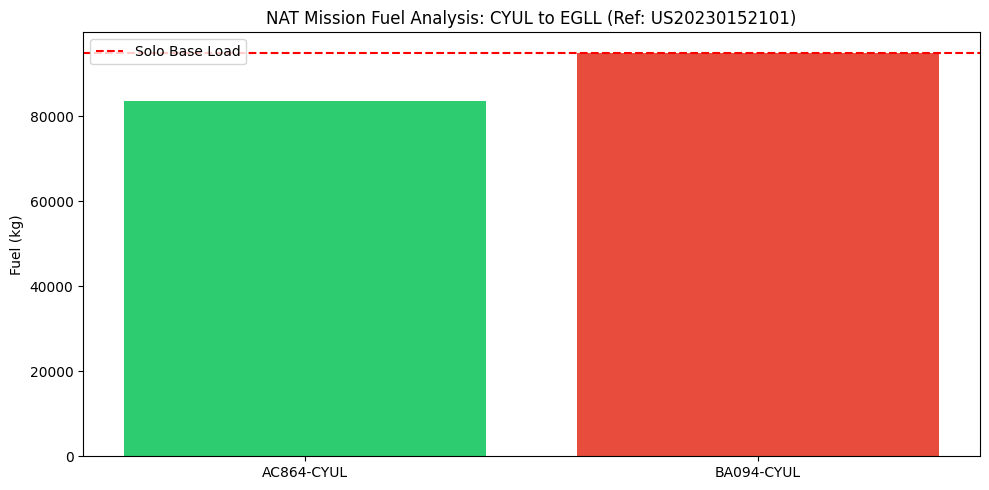

In [5]:
import asyncio
import random
import os
import getpass
from typing import Dict, Any
from openai import AsyncOpenAI
import nest_asyncio
import matplotlib.pyplot as plt
import pandas as pd
from pydantic import Field

# Required for execution in Jupyter/Colab environments
nest_asyncio.apply()

from nat.cli.register_workflow import register_function
from nat.data_models.function import FunctionBaseConfig
from nat.cli.type_registry import GlobalTypeRegistry

# 1. Setup Environment
try:
    GlobalTypeRegistry.get()._registered_functions.clear()
except Exception:
    pass

if "NVIDIA_API_KEY" not in os.environ:
    os.environ["NVIDIA_API_KEY"] = getpass.getpass("Enter your NVIDIA API key: ")

client = AsyncOpenAI(
    base_url="https://integrate.api.nvidia.com/v1",
    api_key=os.environ["NVIDIA_API_KEY"]
)

# 2. Transatlantic Formation Data Models (Ref: US20230152101) [cite: 9]
class RouteWeatherInput(FunctionBaseConfig, name="route_weather"):
    flight_id: str = Field(...)
    origin: str = Field(default="CYUL")
    destination: str = Field(default="EGLL")

class NATPairingInput(FunctionBaseConfig, name="nat_pairing"):
    """
    Implements pairing for North Atlantic Tracks (NAT) based on navigational
    alignment and wake mitigation requirements.
    """
    lead_id: str = Field(...)
    follower_id: str = Field(...)
    oceanic_track: str = Field(default="NAT-A")
    # G01C 21 Navigational offsets for wake turbulence mitigation
    horiz_sep_km: float = Field(default=3.7) # ~2 nautical miles
    vert_sep_ft: float = Field(default=1000.0)

class FuelDynamicsInput(FunctionBaseConfig, name="fuel_dynamics"):
    base_load: float = Field(default=95000.0) # Base fuel in kg for CYUL-EGLL
    is_rerouted: bool = Field(default=False)
    in_formation: bool = Field(default=False) # Aerodynamic benefit parameter

class BriefingTemplateInput(FunctionBaseConfig, name="briefing_template"):
    id: str = Field(...)
    decision: str = Field(...)
    track: str = Field(...)
    current_fuel: float = Field(...)
    planned_fuel: float = Field(...)
    formation_status: str = Field(default="SOLO")

# 3. Multi-Agent Logic
@register_function(config_type=RouteWeatherInput)
async def register_weather(config, builder):
    async def logic(input_data):
        condition = random.choice(["CLEAR", "TURBULENCE"])
        return {"condition": condition, "location": "North Atlantic"}
    yield logic

@register_function(config_type=NATPairingInput)
async def register_formation(config, builder):
    """Navigational logic for pairing aircraft (Ref: US20230152101) [cite: 19, 41]"""
    async def logic(input_data):
        # Pairing succeeds if flights are from compatible fleets (e.g., AC)
        can_pair = "AC" in input_data.lead_id and "AC" in input_data.follower_id
        return {
            "paired": can_pair,
            "drag_reduction": 0.12 if can_pair else 0.0, # 12% benefit
            "track": input_data.oceanic_track
        }
    yield logic

@register_function(config_type=FuelDynamicsInput)
async def register_fuel(config, builder):
    async def logic(input_data):
        # Formation flight reduces fuel consumption via reduced air resistance
        fuel_mod = 0.88 if input_data.in_formation else 1.0
        reroute_penalty = 5000 if input_data.is_rerouted else 0
        final_load = (input_data.base_load + reroute_penalty) * fuel_mod
        return {"current": input_data.base_load, "total_est": final_load}
    yield logic

@register_function(config_type=BriefingTemplateInput)
async def register_briefing(config, builder):
    async def logic(input_data):
        system_msg = (
            "You are a Transatlantic Flight Dispatcher. Use the 'NAT Formation Dispatch' format. "
            "Highlight Oceanic Track ID, Formation Pairing status, and Wake Turbulence offsets."
        )
        user_msg = (f"ID: {input_data.id}, Track: {input_data.track}, Status: {input_data.formation_status}, "
                    f"Final Fuel: {input_data.planned_fuel}kg.")

        response = await client.chat.completions.create(
            model="meta/llama-3.1-8b-instruct",
            messages=[{"role": "system", "content": system_msg}, {"role": "user", "content": user_msg}],
            temperature=0.1
        )
        return {"report": response.choices[0].message.content}
    yield logic

# 4. Transatlantic Orchestration Engine
async def run_london_mission(flight_id, partner_id):
    async with register_weather(None, None) as weather_agent, \
               register_formation(None, None) as formation_agent, \
               register_fuel(None, None) as fuel_agent, \
               register_briefing(None, None) as briefing_agent:

        # Step 1: Concurrent Weather & Navigational Pairing Assessment
        w, f = await asyncio.gather(
            weather_agent(RouteWeatherInput(flight_id=flight_id)),
            formation_agent(NATPairingInput(lead_id=flight_id, follower_id=partner_id))
        )

        decision = "CLEARED" if w["condition"] == "CLEAR" else "RE-ROUTE"

        # Step 2: Compute Fuel with Formation Savings
        fuel_data = await fuel_agent(FuelDynamicsInput(
            in_formation=f["paired"],
            is_rerouted=(decision == "RE-ROUTE")
        ))

        # Step 3: Generate Professional Bulletin
        report = await briefing_agent(BriefingTemplateInput(
            id=flight_id,
            decision=decision,
            track=f["track"],
            current_fuel=95000.0,
            planned_fuel=fuel_data["total_est"],
            formation_status="PAIRED" if f["paired"] else "SOLO"
        ))

        return {
            "id": flight_id,
            "status": f["paired"],
            "fuel": fuel_data["total_est"],
            "text": report["report"]
        }

# 5. Visualizer and Main Execution
def plot_mission_results(results):
    df = pd.DataFrame(results)
    df.to_csv("transatlantic_mission_results.csv", index=False)

    labels = [r['id'] for r in results]
    fuel_values = [r['fuel'] for r in results]
    colors = ['#2ecc71' if r['status'] else '#e74c3c' for r in results]

    plt.figure(figsize=(10, 5))
    plt.bar(labels, fuel_values, color=colors)
    plt.axhline(y=95000, color='r', linestyle='--', label='Solo Base Load')
    plt.title('NAT Mission Fuel Analysis: CYUL to EGLL (Ref: US20230152101)')
    plt.ylabel('Fuel (kg)')
    plt.legend()
    plt.tight_layout()
    plt.savefig('transatlantic_pairing_analysis.png')

async def simulate():
    print("="*60 + "\n   NAT DISPATCH: MONTREAL (CYUL) -> LONDON (EGLL)\n" + "="*60)

    # Scenarios: Paired vs Solo
    tasks = [
        run_london_mission("AC864-CYUL", "AC567-CYUL"), # Target pairing
        run_london_mission("BA094-CYUL", "NON-COMPATIBLE") # Target solo
    ]

    results = await asyncio.gather(*tasks)
    for r in results:
        print(f"\n{r['text']}\n" + "-"*40)

    plot_mission_results(results)

if __name__ == "__main__":
    await simulate()